In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("/Users/daviderickson/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all-cleaned.csv")

In [ ]:
print('Rows, columns: ', df.shape)
print('Years/state', len(df)/50)
print('YEARs', df['YEAR'].min(), '--' , df['YEAR'].max())
print('\nSTATEs\n', df['STATE'].unique(), '\n')
print('Features:\n', df.columns.tolist(), '\n')

Number of features:  23
Test scores are correlated with time.
Revenues and expenditures are highly correlated with each other.
School populations are highly correlated with each other.
School pops and Revs/Expenditures are highly intercorrelated.
Test scores are highly correlated with each other. AVG_8_READING_SCORE less so than the others.


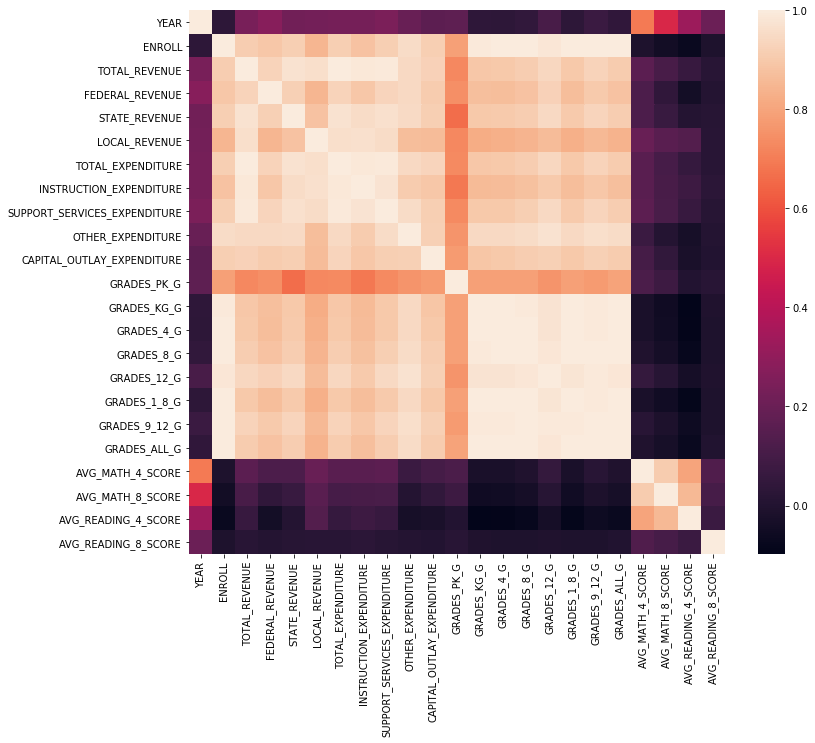

In [6]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print('Number of features: ', len(corr))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr)
print('Test scores are correlated with time.')
print('Revenues and expenditures are highly correlated with each other.')
print('School populations are highly correlated with each other.')
print('School pops and Revs/Expenditures are highly intercorrelated.')
print('Test scores are highly correlated with each other. AVG_8_READING_SCORE less so than the others.')

PCA 

In [7]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
pca.fit(df1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1487, 25)
(412, 25)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

3 PCA components explain the variance


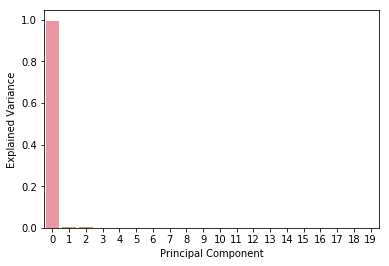

In [83]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_[0:20]))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
print('3 PCA components explain the variance')

(412, 54)
(1487, 25)


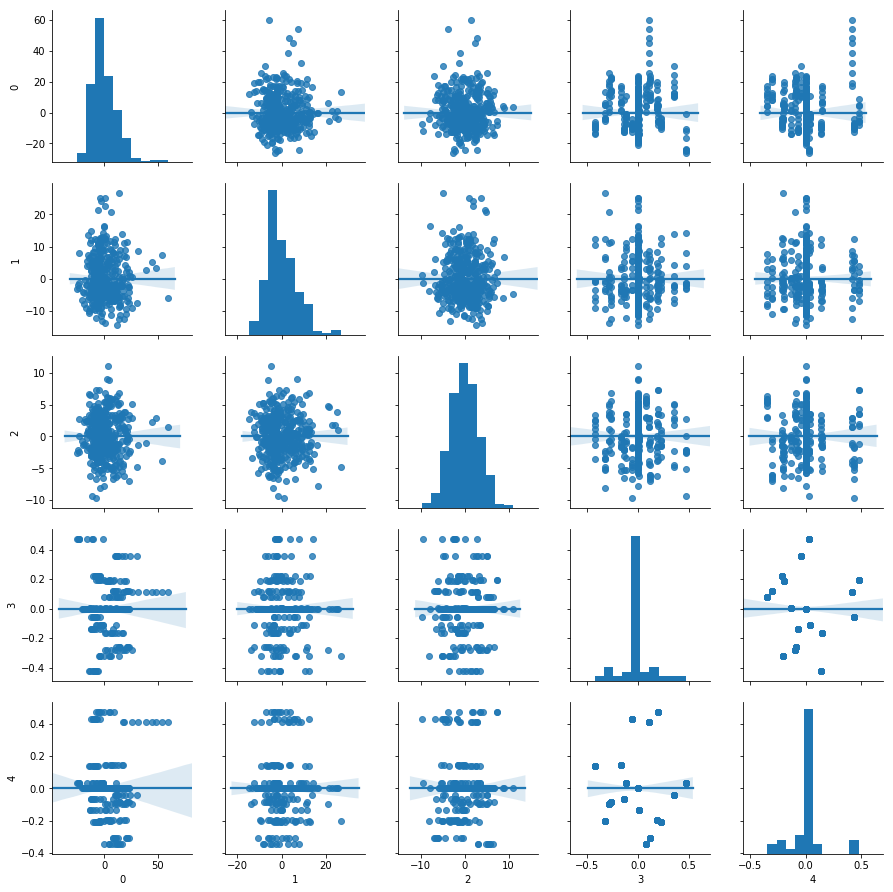

In [10]:
X_pca_df = pd.DataFrame(X_pca)
print(X_pca_df.shape)
print(df.shape)
sns.pairplot(X_pca_df.iloc[:,0:5], kind='reg')

(54, 54)
Trivial: PCA Features not correlated


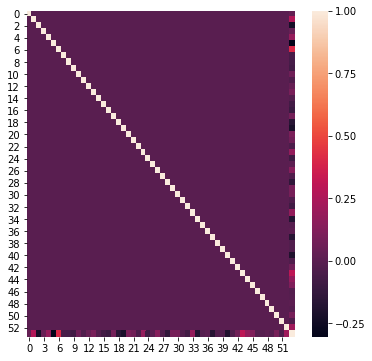

In [11]:
#plt.figure(figsize=(15,15))
df_pca = pd.DataFrame(X_pca)
corr_pca = df_pca.corr()
print(corr_pca.shape)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_pca)
print('Trivial: PCA Features not correlated')

In [12]:
shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']


In [13]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df, new_cols):
    most_recent_value= pd.Series(data=None, index=new_cols)
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')
    
    for new_col in new_cols:
        df_scratch2= df_scratch[df_scratch[new_col].notna()]
        if df_scratch2.notna().any().any(): 
            most_recent_value[new_col]= df_scratch2[new_col].iloc[-1]
        else:
            most_recent_value[new_col]= np.nan #Should handle these cases better
    # for col in most_recent_value.columns:
    labels = ['recent_' + col for col in new_cols]
    most_recent_value.set_axis(labels, axis=0, inplace=True)
    return most_recent_value

In [14]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [15]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [16]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [17]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

#Models want to know about drop-out rate
df['fracn_GRADES_12div8_G'] = np.zeros(len(df))
#Subtract take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, ['fracn_GRADES_12div8_G']]= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [18]:
print(df.shape)
print('Fracn notna: ', np.count_nonzero(df['fracn_GRADES_12div8_G'].notna()) / len(df))
df['fracn_GRADES_12div8_G'].describe()

(1487, 45)
Fracn notna:  0.9186281102891728


count    1366.000000
mean        0.693437
std         0.362487
min         0.000000
25%         0.708520
50%         0.844271
75%         0.918171
max         1.139928
Name: fracn_GRADES_12div8_G, dtype: float64

In [19]:
# Add recent_ features

#print('Pre:\n', df.columns, '\n')

cols_add_recent = ['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', \
                   'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', \
                   'fracn_rev_FEDERAL_REVENUE','fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', \
                   'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G','fracn_enroll_GRADES_12_G', \
                   'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', \
                   'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', \
                   'exp_per_rev', 'fracn_GRADES_12div8_G']

for index, data in df.iterrows(): 
    recent_test= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df, new_cols=cols_add_recent)
    for col in recent_test.index.tolist(): 
        df.loc[index, col] = recent_test[col]
print('recent_ features added:')
print(cols_add_recent)


recent_ features added:
['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', 'fracn_rev_FEDERAL_REVENUE', 'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', 'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G', 'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', 'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', 'exp_per_rev', 'fracn_GRADES_12div8_G']


In [20]:
print('Adding delta_ features')

delta_cols = ['ENROLL', 'TOTAL_REVENUE', 'GRADES_ALL_G', 'GRADES_4_G', \
            # This would bleed info from future
              # Would need delta_ of previous timepoint to get delta_ info for _SCORE
            # 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', \
           'fracn_rev_FEDERAL_REVENUE','fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G', \
           'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G','fracn_enroll_GRADES_12_G', \
           'fracn_enroll_GRADES_1_8_G', 'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue', \
           'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person', \
           'exp_per_rev', 'fracn_GRADES_12div8_G']

for col in delta_cols:
    df['delta_{}'.format(col)] = df[col] - df['recent_{}'.format(col)]
    #df=df.drop(col, axis=1)
    print('delta_{}'.format(col))

print('delta_ features added')

Adding delta_ features
delta_ENROLL
delta_TOTAL_REVENUE
delta_GRADES_ALL_G
delta_GRADES_4_G
delta_fracn_rev_FEDERAL_REVENUE
delta_fracn_enroll_GRADES_PK_G
delta_fracn_enroll_GRADES_KG_G
delta_fracn_enroll_GRADES_4_G
delta_fracn_enroll_GRADES_8_G
delta_fracn_enroll_GRADES_12_G
delta_fracn_enroll_GRADES_1_8_G
delta_fracn_enroll_GRADES_9_12_G
delta_avg_total_revenue
delta_avg_total_expenditure
delta_fracn_schoolage
delta_rev_per_person
delta_exp_per_rev
delta_fracn_GRADES_12div8_G
delta_ features added


In [27]:
"""
Drop the 2 rows in DISTRICT_OF_COLUMBIAs that data have unreasonably small GRADES_ALL_G
AND both have a duplicated PRIMARY_KEY 
"""
df = df[df['GRADES_ALL_G']>40000]

In [28]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have incredibly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,delta_fracn_enroll_GRADES_8_G,delta_fracn_enroll_GRADES_12_G,delta_fracn_enroll_GRADES_1_8_G,delta_fracn_enroll_GRADES_9_12_G,delta_avg_total_revenue,delta_avg_total_expenditure,delta_fracn_schoolage,delta_rev_per_person,delta_exp_per_rev,delta_fracn_GRADES_12div8_G


In [29]:
df[df['avg_total_expenditure'] > 100]['AVG_MATH_4_SCORE']

Series([], Name: AVG_MATH_4_SCORE, dtype: float64)

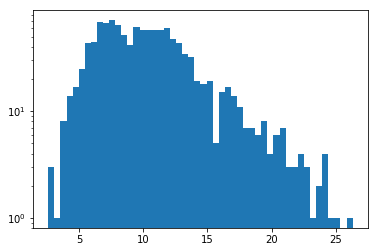

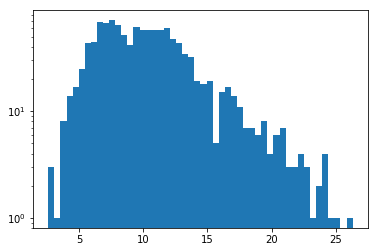

In [30]:
"""
Drop the 2 rows that have much higher avg_total_expenditure than all other rows. 
These rows also have a duplicated primary key
"""
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);
plt.show()
# df[df['avg_total_expenditure'] > 100]

# Drop the 2 outlier rows
df = df[df['avg_total_expenditure'] < 100]

plt.hist('avg_total_expenditure', bins=50, log=True, data=df);
plt.show()

In [31]:
df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,delta_fracn_enroll_GRADES_8_G,delta_fracn_enroll_GRADES_12_G,delta_fracn_enroll_GRADES_1_8_G,delta_fracn_enroll_GRADES_9_12_G,delta_avg_total_revenue,delta_avg_total_expenditure,delta_fracn_schoolage,delta_rev_per_person,delta_exp_per_rev,delta_fracn_GRADES_12div8_G
count,1214.000000,1.164000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.214000e+03,1.164000e+03,...,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1113.000000,1114.000000,1164.000000,1164.000000
mean,2003.530478,9.166842e+05,8.922752e+06,7.547590e+05,4.133878e+06,4.034115e+06,9.036754e+06,4.675527e+06,2.630462e+06,4.227990e+05,...,-0.000104,0.000450,-0.001868,0.000891,0.369862,0.361695,-0.001093,0.375077,-0.001031,0.041006
std,6.906654,1.054153e+06,1.131445e+07,1.121221e+06,5.300473e+06,5.310380e+06,1.158441e+07,6.075892e+06,3.234789e+06,5.168056e+05,...,0.001650,0.001806,0.004994,0.004598,0.603082,0.600104,0.045645,0.539011,0.032956,0.171691
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,-0.009481,-0.007452,-0.036412,-0.037108,-6.714628,-6.653822,-0.847495,-2.970742,-0.196380,-0.136397
25%,1998.000000,2.673202e+05,2.189045e+06,1.902835e+05,1.165477e+06,7.148415e+05,2.172325e+06,1.172759e+06,6.376580e+05,1.034492e+05,...,-0.001052,-0.000654,-0.004488,-0.001598,0.158836,0.125562,-0.003269,0.177460,-0.018046,-0.001354
50%,2004.000000,6.531095e+05,5.063910e+06,4.002160e+05,2.502170e+06,2.036751e+06,5.185218e+06,2.641565e+06,1.521478e+06,2.710355e+05,...,-0.000152,0.000452,-0.001706,0.000926,0.351789,0.349207,0.000993,0.342298,-0.000665,0.003950
75%,2009.750000,1.014540e+06,1.066705e+07,8.184432e+05,4.863387e+06,4.703754e+06,1.060568e+07,5.532012e+06,3.143274e+06,5.135950e+05,...,0.000839,0.001504,0.000848,0.003573,0.576301,0.583844,0.005616,0.542531,0.016038,0.016323
max,2015.000000,6.307022e+06,7.462693e+07,9.990221e+06,4.318764e+07,3.494151e+07,7.661886e+07,4.195426e+07,2.231086e+07,3.759373e+06,...,0.010189,0.008643,0.039099,0.024670,5.820202,7.198079,0.347254,9.194547,0.177213,1.010082


In [32]:
#sns.pairplot(df, kind='scatter')

(83, 83)


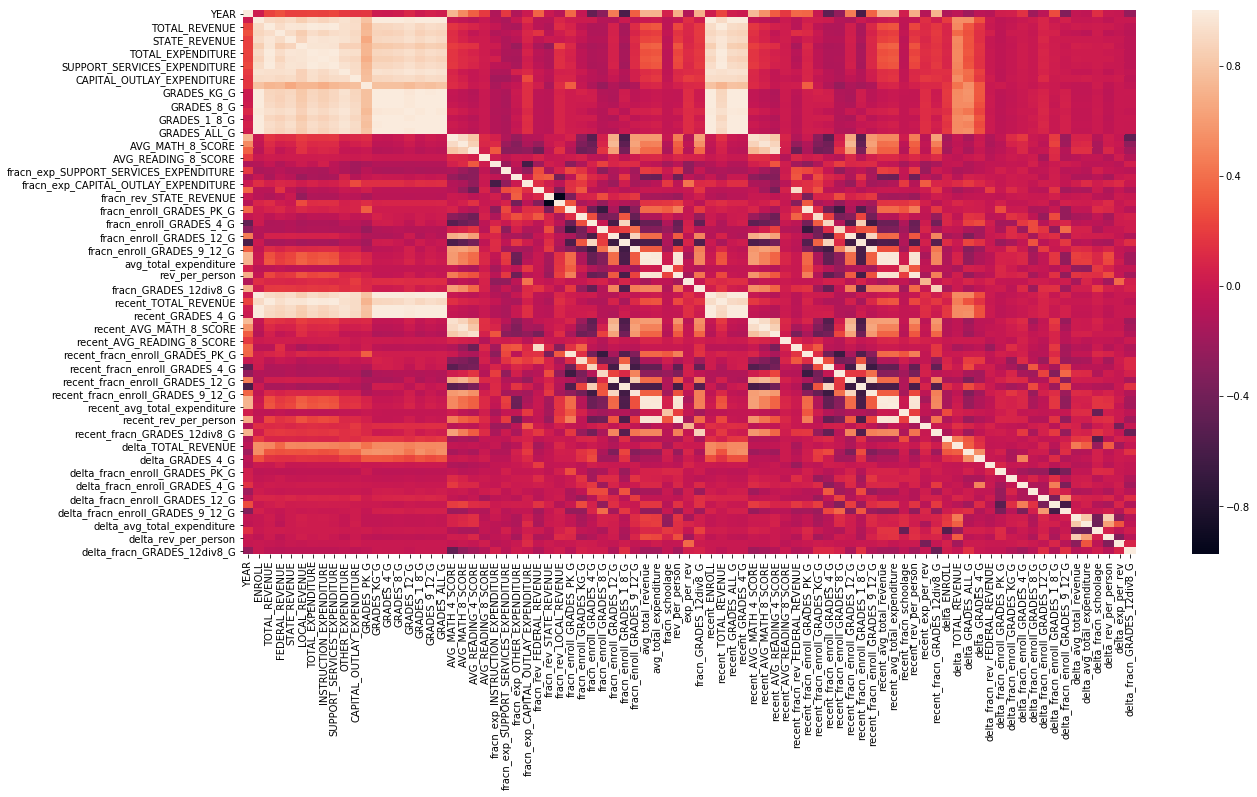

In [33]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

In [34]:
# KMeans Clustering

from sklearn.cluster import KMeans
# df.drop(['AVG_MATH_4_SCORE'], axis=1)
print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)

kmeans = KMeans(n_clusters=10)
y_pred = kmeans.fit_predict(df1)

(1214, 85)
(376, 85)


In [35]:
print(df1.columns)

Index(['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE',
       'AVG_READING_8_SCORE', 'fracn_exp_INSTRUCTION_EXPENDITURE',
       'fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_exp_CAPITAL_OUTLAY_EXPENDITURE', 'fracn_rev_FEDERAL_REVENUE',
       'fracn_rev_STATE_REVENUE',
       ...
       'STATE_SOUTH_DAKOTA', 'STATE_TENNESSEE', 'STATE_TEXAS', 'STATE_UTAH',
       'STATE_VERMONT', 'STATE_VIRGINIA', 'STATE_WASHINGTON',
       'STATE_WEST_VIRGINIA', 'STATE_WISCONSIN', 'STATE_WYOMING'],
      dtype='object', length=115)


In [36]:
kmeans.cluster_centers_
centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=df1.columns)
centers.sort_values('AVG_MATH_4_SCORE')

,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,fracn_exp_INSTRUCTION_EXPENDITURE,fracn_exp_SUPPORT_SERVICES_EXPENDITURE,fracn_exp_OTHER_EXPENDITURE,fracn_exp_CAPITAL_OUTLAY_EXPENDITURE,fracn_rev_FEDERAL_REVENUE,fracn_rev_STATE_REVENUE,...,STATE_SOUTH_DAKOTA,STATE_TENNESSEE,STATE_TEXAS,STATE_UTAH,STATE_VERMONT,STATE_VIRGINIA,STATE_WASHINGTON,STATE_WEST_VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
7,232.382119,272.375381,210.547299,261.197053,0.482619,0.289437,0.049299,0.109475,0.121411,0.542025,...,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,234.497725,275.591533,216.219588,264.522519,0.577123,0.257539,0.033826,0.098220,0.080298,0.465591,...,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,234.675140,277.182697,216.351586,264.212222,0.508482,0.268001,0.042800,0.122610,0.092378,0.421359,...,0.00,0.000000e+00,6.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,234.911654,276.994248,216.927144,263.994710,0.507608,0.297317,0.055083,0.106693,0.105595,0.517477,...,0.00,3.571429e-02,3.122502e-17,4.761905e-02,2.428613e-17,3.122502e-17,2.428613e-17,1.190476e-02,2.428613e-17,2.428613e-17
6,236.456899,279.278780,218.624882,263.571181,0.517793,0.307002,0.045402,0.093021,0.105423,0.498573,...,0.05,0.000000e+00,0.000000e+00,2.500000e-02,5.833333e-02,0.000000e+00,6.938894e-18,5.000000e-02,6.938894e-18,5.833333e-02
0,238.549823,281.193621,220.513461,263.688438,0.513294,0.298647,0.050747,0.094202,0.090859,0.474796,...,0.00,7.352941e-02,1.734723e-17,2.081668e-17,2.081668e-17,2.941176e-02,4.411765e-02,2.081668e-17,5.882353e-02,2.081668e-17
5,238.745820,280.007750,220.915413,264.435230,0.507705,0.305246,0.044482,0.095626,0.085568,0.448948,...,0.00,1.387779e-17,1.387779e-17,-1.040834e-17,-1.040834e-17,1.387779e-17,-1.040834e-17,-1.040834e-17,-1.040834e-17,-1.040834e-17
8,241.779883,285.290398,220.025401,267.059119,0.516538,0.261313,0.040064,0.117152,0.099412,0.410384,...,0.00,0.000000e+00,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,242.574742,285.041783,224.832063,262.725525,0.509313,0.306868,0.042677,0.084372,0.082138,0.371873,...,0.00,1.040834e-17,4.000000e-02,-1.040834e-17,-1.040834e-17,1.040834e-17,-1.040834e-17,-1.040834e-17,-1.040834e-17,-1.040834e-17
9,243.926026,286.933209,224.794030,264.376687,0.529326,0.302082,0.042114,0.083781,0.078500,0.486682,...,0.00,-3.469447e-18,-3.469447e-18,3.469447e-18,3.469447e-18,1.666667e-01,1.111111e-01,3.469447e-18,8.333333e-02,3.469447e-18


In [37]:
centers['AVG_MATH_4_SCORE']

0    238.549823
1    234.497725
2    234.911654
3    242.574742
4    234.675140
5    238.745820
6    236.456899
7    232.382119
8    241.779883
9    243.926026
Name: AVG_MATH_4_SCORE, dtype: float64

In [38]:
centers.describe()

,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,fracn_exp_INSTRUCTION_EXPENDITURE,fracn_exp_SUPPORT_SERVICES_EXPENDITURE,fracn_exp_OTHER_EXPENDITURE,fracn_exp_CAPITAL_OUTLAY_EXPENDITURE,fracn_rev_FEDERAL_REVENUE,fracn_rev_STATE_REVENUE,...,STATE_SOUTH_DAKOTA,STATE_TENNESSEE,STATE_TEXAS,STATE_UTAH,STATE_VERMONT,STATE_VIRGINIA,STATE_WASHINGTON,STATE_WEST_VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
mean,237.849983,279.988940,218.975087,263.978269,0.516980,0.289345,0.044649,0.100515,0.094158,0.463771,...,0.005000,1.092437e-02,1.306667e-01,7.261905e-03,5.833333e-03,1.960784e-02,1.552288e-02,6.190476e-03,1.421569e-02,5.833333e-03
std,3.912477,4.689967,4.284581,1.481915,0.024197,0.019542,0.005964,0.013120,0.013734,0.051836,...,0.015811,2.469518e-02,2.656871e-01,1.621118e-02,1.844662e-02,5.249143e-02,3.633555e-02,1.584124e-02,3.052102e-02,1.844662e-02
min,232.382119,272.375381,210.547299,261.197053,0.482619,0.257539,0.033826,0.083781,0.078500,0.371873,...,0.000000,-3.469447e-18,-3.469447e-18,-1.040834e-17,-1.040834e-17,0.000000e+00,-1.040834e-17,-1.040834e-17,-1.040834e-17,-1.040834e-17
25%,234.734268,277.041360,216.495476,263.600495,0.507899,0.273360,0.042255,0.093316,0.082996,0.428257,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,237.503361,279.643265,219.325141,264.103466,0.511304,0.297982,0.043641,0.096923,0.091619,0.470193,...,0.000000,0.000000e+00,1.561251e-17,0.000000e+00,0.000000e+00,5.204170e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,241.021367,284.079743,220.814925,264.420595,0.517479,0.304455,0.048324,0.108780,0.103920,0.495600,...,0.000000,1.301043e-17,3.000000e-02,1.647987e-17,1.647987e-17,2.688821e-17,1.994932e-17,1.647987e-17,1.994932e-17,1.647987e-17
max,243.926026,286.933209,224.832063,267.059119,0.577123,0.307002,0.055083,0.122610,0.121411,0.542025,...,0.050000,7.352941e-02,6.666667e-01,4.761905e-02,5.833333e-02,1.666667e-01,1.111111e-01,5.000000e-02,8.333333e-02,5.833333e-02


In [39]:
print(y_pred)

[2 6 2 2 6 9 2 2 6 4 2 6 6 0 2 2 6 2 0 6 6 6 0 6 2 2 3 0 2 2 6 1 2 2 6 6 5
 9 6 6 0 2 2 2 2 6 0 9 0 0 6 6 6 6 5 6 0 6 5 2 2 5 2 2 4 6 6 0 0 6 0 6 2 6
 0 6 1 2 0 6 6 5 9 6 6 5 0 2 2 2 2 6 0 9 5 0 6 0 6 6 6 6 5 6 4 0 6 5 2 2 5
 6 2 6 2 4 6 6 9 0 6 0 6 2 6 0 2 7 0 0 6 6 3 5 6 6 3 9 2 2 2 2 6 0 9 5 0 2
 0 6 6 2 6 3 6 8 9 6 5 2 2 3 6 2 6 0 4 6 6 9 0 6 0 6 0 6 0 2 7 0 0 6 6 3 5
 6 6 3 9 2 2 2 0 6 9 9 5 0 2 0 6 6 2 6 3 2 8 9 6 3 2 2 3 6 0 6 0 8 2 6 9 9
 6 0 6 0 6 0 2 7 0 0 6 6 3 5 6 6 3 9 2 2 2 0 6 9 9 5 0 2 0 6 2 2 6 3 2 1 5
 6 3 2 2 3 6 0 6 0 8 2 6 9 9 6 9 6 0 6 0 2 7 0 0 6 6 3 5 6 6 3 9 2 2 0 0 6
 9 9 5 0 2 0 6 2 2 6 3 6 1 9 6 3 2 2 3 6 0 6 0 8 2 6 9 9 2 9 6 0 6 0 2 0 0
 6 6 3 5 6 6 3 9 2 2 0 0 6 9 5 5 9 2 0 6 2 2 6 3 2 1 9 6 3 2 3 6 0 6 0 8 2
 6 9 9 6 9 6]


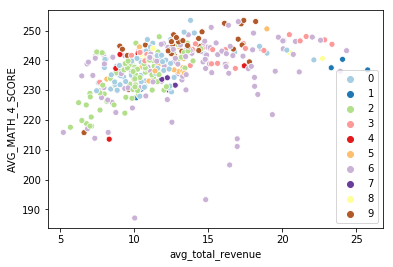

In [40]:
sns.scatterplot('avg_total_revenue', 'AVG_MATH_4_SCORE' , hue=y_pred.astype(np.int), data=df1, \
                legend='full', palette="Paired")

In [41]:
# Affinity Propagation Clustering

from sklearn.cluster import AffinityPropagation
# df.drop(['AVG_MATH_4_SCORE'], axis=1)
print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)

aff_prop = AffinityPropagation()
y_aff_prop = aff_prop.fit_predict(df1)

(1214, 85)
(376, 85)


In [42]:
aff_prop.cluster_centers_
centers = pd.DataFrame(data=aff_prop.cluster_centers_, columns=df1.columns)
# centers.sort_values('AVG_MATH_4_SCORE')

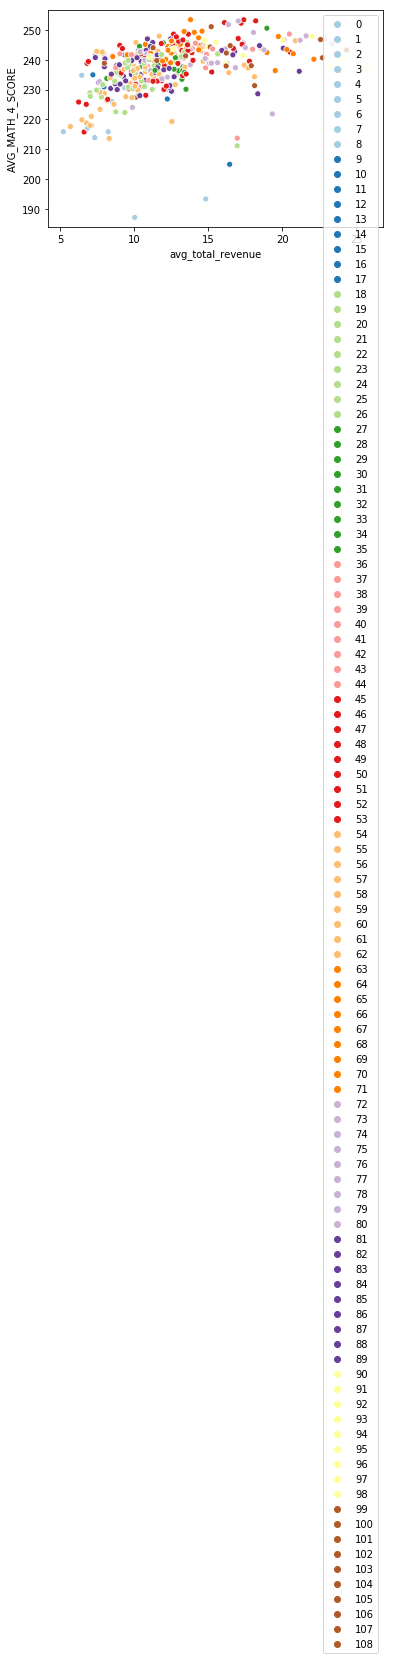

In [43]:
sns.scatterplot('avg_total_revenue', 'AVG_MATH_4_SCORE' , hue=y_aff_prop.astype(np.int), data=df1, \
                legend='full', palette="Paired")

In [44]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
pca.fit(df1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1214, 85)
(376, 85)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Explained Variance')

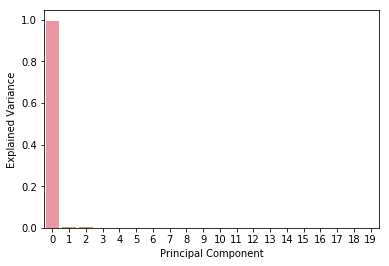

In [45]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_[0:20]))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

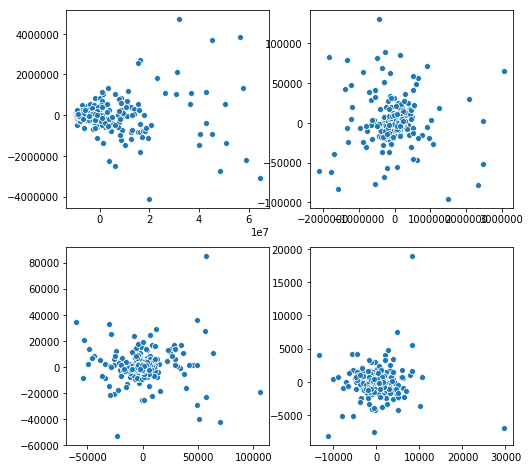

In [46]:
X_pca = pca.fit(df1).transform(df1)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0], X_pca[:,1])
plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,2], X_pca[:,3])
plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,4], X_pca[:,5])
plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,6], X_pca[:,7])

In [47]:
"""g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')"""

'g = sns.FacetGrid(df, row="STATE") \ng.map(plt.scatter, \'YEAR\', \'AVG_MATH_4_SCORE\')'

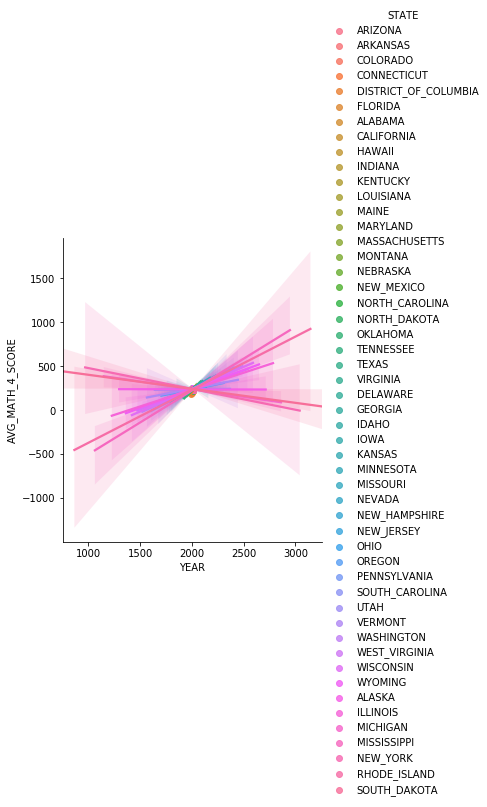

In [48]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

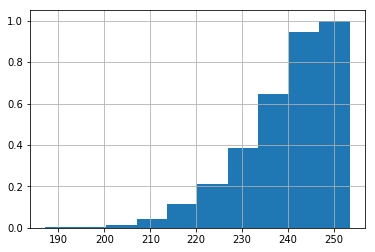

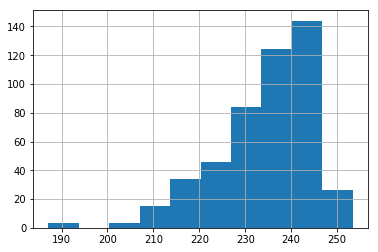

In [49]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

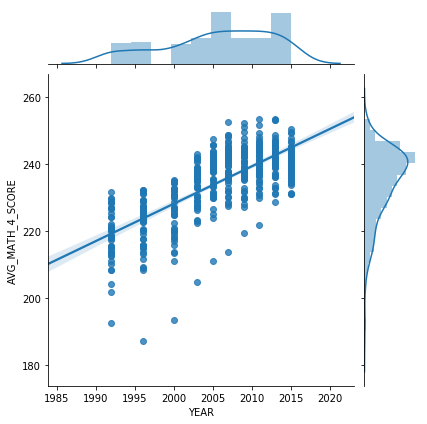

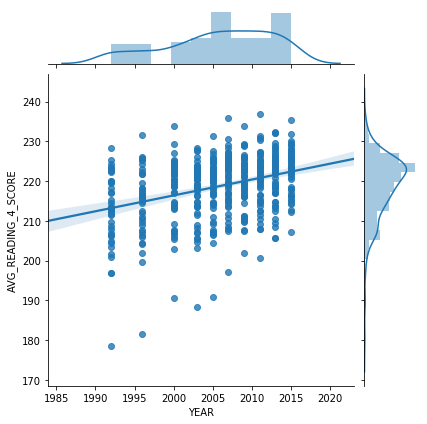

In [50]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

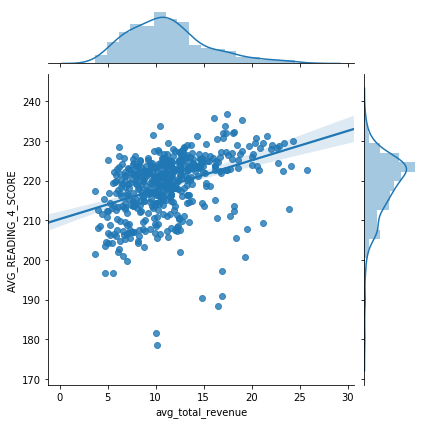

In [51]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

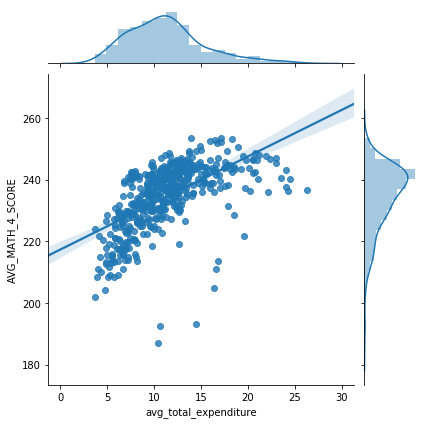

In [52]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

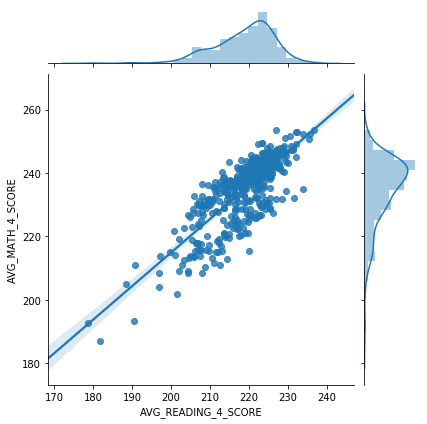

In [53]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

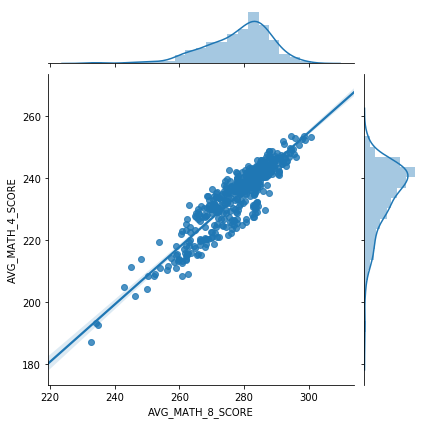

In [54]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [55]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

Index(['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'fracn_exp_INSTRUCTION_EXPENDITURE',
       'fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_exp_CAPITAL_OUTLAY_EXPENDITURE', 'fracn_rev_FEDERAL_REVENUE',
       'fracn_rev_STATE_REVENUE', 'fracn_rev_LOCAL_REVENUE',
       'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G',
       'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G',
       'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_1_8_G',
       'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue',
       'avg_total_expenditure', 'fracn_schoolage', 'rev_per_person',
       'exp_per_rev', 

'\nPredefinedSplit won\'t work because it folds in future data\n\ntest_fold = df1.loc[:,\'YEAR\'].values\nps = PredefinedSplit(test_fold)\nprint(ps.get_n_splits())\nfor train_index, test_index in ps.split():\n    print("Train:", train_index, "Test:", test_index)\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]    \n'

In [56]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [57]:
print(index)
print(index_list)
print(train_score)
print(test_score)

20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.97257069 0.95268465 0.96876557 0.96862911 0.97035441 0.96996462
 0.97456327 0.97971799 0.98152994 0.98036929 0.9800377  0.98053562
 0.98226575 0.97737915 0.98265405 0.9807177  0.98336542 0.98245572
 0.98268336 0.98061969]
[-0.55144612  0.18820988  0.44387361  0.72308618  0.71745821  0.71848472
  0.92226137  0.86458002  0.712769    0.81501954  0.87565221  0.82129592
  0.90614584  0.83362451  0.62840201  0.83255744  0.81789074  0.19878005
  0.83752807  0.54885771]


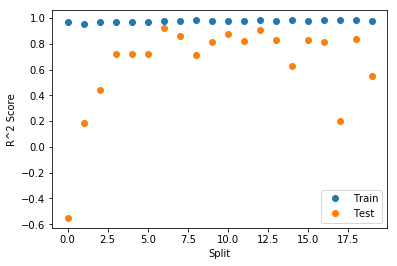

In [58]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [59]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

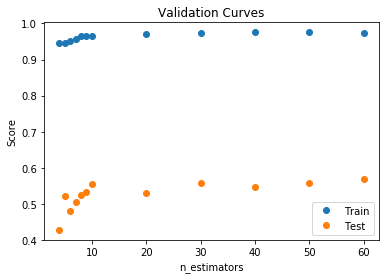

In [60]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [61]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1310: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes' 18 instead of 30).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


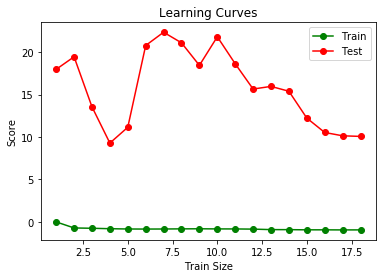

In [62]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [63]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

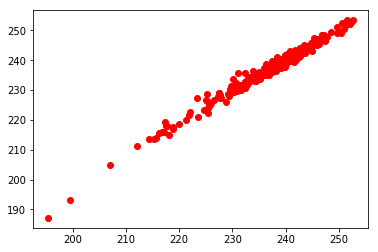

In [64]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [65]:
rf_model.score(X,y)

0.9817420377331879

In [66]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

,importance
recent_AVG_MATH_4_SCORE,0.567318
recent_AVG_MATH_8_SCORE,0.268020
recent_AVG_READING_4_SCORE,0.018968
YEAR,0.011627
recent_TOTAL_REVENUE,0.006559
GRADES_12_G,0.006511
fracn_enroll_GRADES_12_G,0.005888
recent_fracn_enroll_GRADES_9_12_G,0.005439
fracn_exp_SUPPORT_SERVICES_EXPENDITURE,0.004630
fracn_enroll_GRADES_KG_G,0.004341


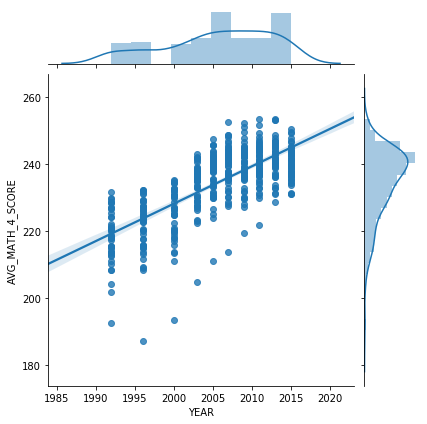

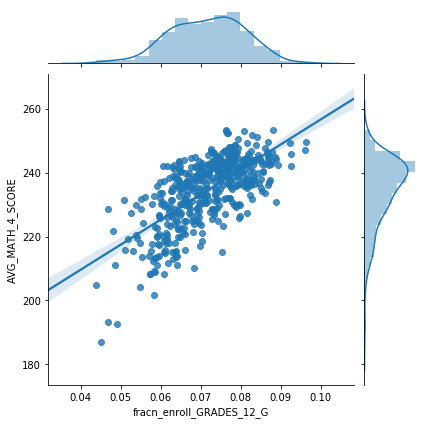

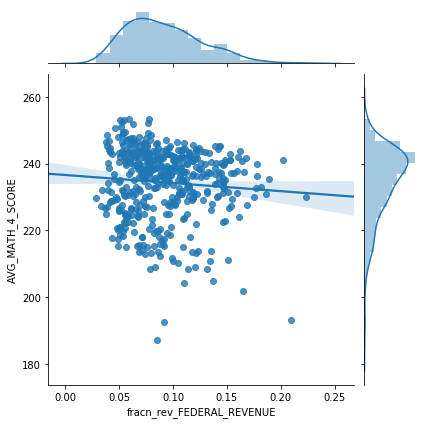

In [67]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [68]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

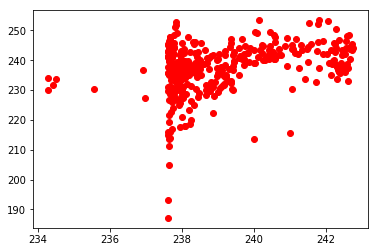

In [69]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

# Lasso

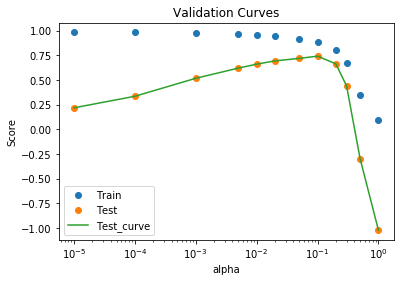

In [70]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [71]:
lasso_best_alpha = 0.1

(30,) (30, 5) (30, 5)


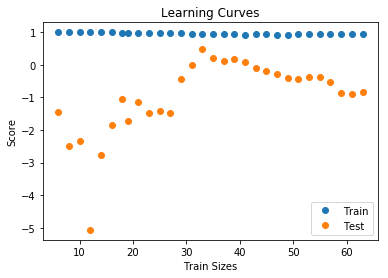

In [72]:
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
#lasso_model.fit(X, y)  
#Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [73]:
"""Plot test data fit"""

'Plot test data fit'

Text(0, 0.5, 'y')

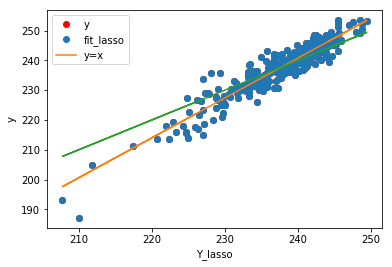

In [74]:

lasso_model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [75]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

(129,)
(129,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0.  0. -0.  0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0.
  0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0.
  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0.
  0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0.
  0. -0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
 -0.  0.  0.]


[(0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (0.0, 'FEDERAL_REVENUE'),
 (0.0, 'GRADES_12_G'),
 (0.0, 'GRADES_1_8_G'),
 (0.0, 'GRADES_4_G'),
 (0.0, 'GRADES_8_G'),
 (0.0, 'GRADES_9_12_G'),
 (0.0, 'GRADES_ALL_G'),
 (0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (0.0, 'INSTRUCTION_EXPENDITURE'),
 (0.0, 'LOCAL_REVENUE'),
 (0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_ALABAMA'),
 (-0.0, 'STATE_ALASKA'),
 (-0.0, 'STATE_ARIZONA'),
 (-0.0, 'STATE_ARKANSAS'),
 (-0.0, 'STATE_CALIFORNIA'),
 (0.0, 'STATE_COLORADO'),
 (-0.0, 'STATE_CONNECTICUT'),
 (-0.0, 'STATE_DELAWARE'),
 (-0.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE_GEORGIA'),
 (-0.0, 'STATE_HAWAII'),
 (0.0, 'STATE_IDAHO'),
 (-0.0, 'STATE_ILLINOIS'),
 (0.0, 'STATE_INDIANA'),
 (0.0, 'STATE_IOWA'),
 (0.0, 'STATE_KANSAS'),
 (-0.0, 'STATE_KENTUCKY'),
 (-0.0, 'STATE_LOUISIANA'),
 (0.0, 'STATE_MAINE'),
 (-0.0, 'STATE_MARYLAND'),
 (0.0, 'STATE_MASSACHUSETTS'),
 (-0.0, 'STATE_MICHIGAN'),
 (0.0, 'STATE_MINNESOTA'),
 (-0.0, 'STATE_MIS

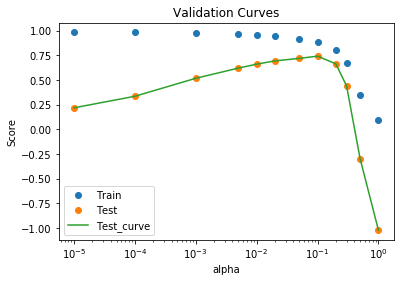

In [76]:
# Lasso 
# Validation Curve
# Scaled Features

scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(normalize=True)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]
"""
#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X_transformed, y=y, param_name="alpha", \
    param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [77]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

print('alpha=', lasso_best_alpha)
model=linear_model.Lasso(alpha=lasso_best_alpha, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

alpha= 0.1
(129,)
(129,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0.  0. -0.  0.
 -0.  0.  0.  0.  0.  0.  5.  1.  1. -0. -0. -0. -0. -0.  0.  0. -0.  0.
  0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0.
  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0.
  0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0.
  0. -0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
 -0.  0.  0.]


[(0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (0.0, 'FEDERAL_REVENUE'),
 (0.0, 'GRADES_12_G'),
 (0.0, 'GRADES_1_8_G'),
 (0.0, 'GRADES_4_G'),
 (0.0, 'GRADES_8_G'),
 (0.0, 'GRADES_9_12_G'),
 (0.0, 'GRADES_ALL_G'),
 (0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (0.0, 'INSTRUCTION_EXPENDITURE'),
 (0.0, 'LOCAL_REVENUE'),
 (0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_ALABAMA'),
 (-0.0, 'STATE_ALASKA'),
 (-0.0, 'STATE_ARIZONA'),
 (-0.0, 'STATE_ARKANSAS'),
 (-0.0, 'STATE_CALIFORNIA'),
 (0.0, 'STATE_COLORADO'),
 (-0.0, 'STATE_CONNECTICUT'),
 (-0.0, 'STATE_DELAWARE'),
 (-0.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE_GEORGIA'),
 (-0.0, 'STATE_HAWAII'),
 (0.0, 'STATE_IDAHO'),
 (-0.0, 'STATE_ILLINOIS'),
 (0.0, 'STATE_INDIANA'),
 (0.0, 'STATE_IOWA'),
 (0.0, 'STATE_KANSAS'),
 (-0.0, 'STATE_KENTUCKY'),
 (-0.0, 'STATE_LOUISIANA'),
 (0.0, 'STATE_MAINE'),
 (-0.0, 'STATE_MARYLAND'),
 (0.0, 'STATE_MASSACHUSETTS'),
 (-0.0, 'STATE_MICHIGAN'),
 (0.0, 'STATE_MINNESOTA'),
 (-0.0, 'STATE_MIS

Text(0, 0.5, 'y')

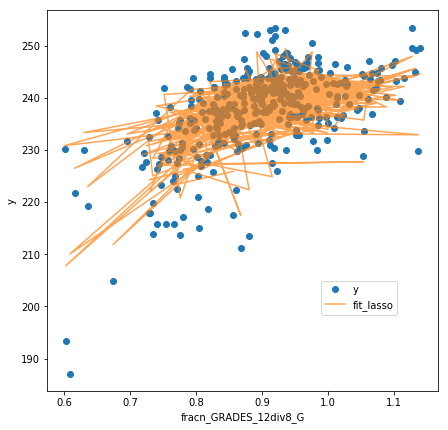

In [78]:
"""fracn_GRADES_12div8_G
is not chosen by Lasso. RandomForest says it's #2 tho. Why?
Plot.
"""
plt.figure(figsize=[7,7])
x1=df1.loc[:,'fracn_GRADES_12div8_G'].values
plt.plot(x1,y,'o')
plt.plot(x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_GRADES_12div8_G")
plt.ylabel("y")

(378,) (378, 129) (378,)
(378,) (378, 129) (378,)
(378,) (378, 129) (378,)
(378,) (378, 129) (378,)


Text(0, 0.5, 'y')

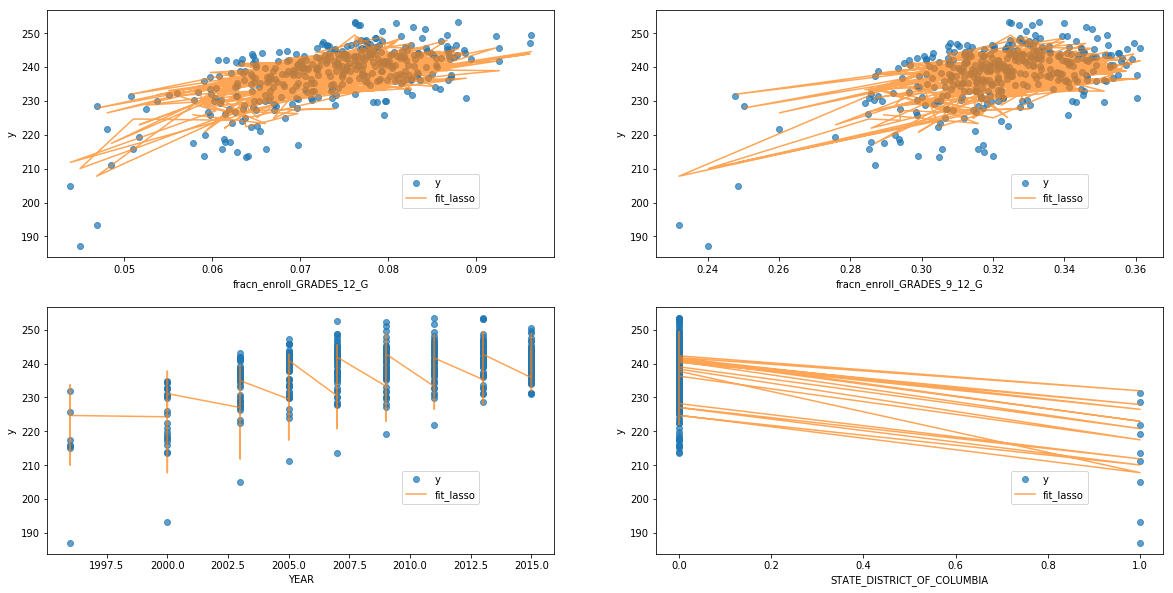

In [79]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

Text(0, 0.5, 'y')

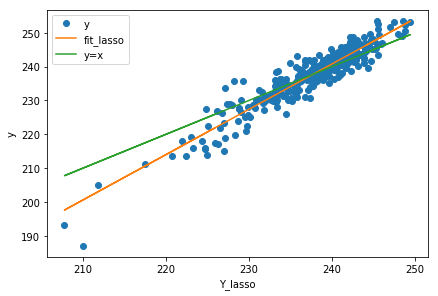

In [80]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

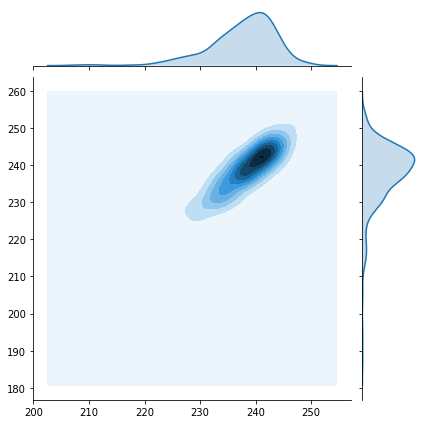

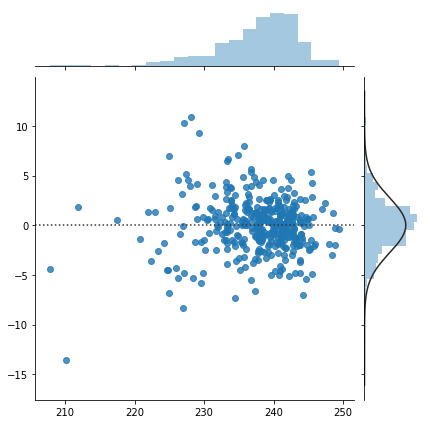

In [81]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

TypeError: 'list' object is not callable

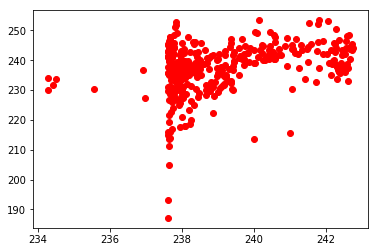

In [82]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""